# Analysis on correlation between mainshocks and surface mass loading

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/home/amand4/notebooks/SLIM/loadquakes.py'>

### Load datasets (GRACE and declustered catalog)

In [2]:
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Events from 2002-04-16 to 2021-12-16 with magnitude >= 5.4
catalog = pd.read_csv('ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64")

ValueError: found the following matches with the input file in xarray's IO backends: ['netcdf4', 'h5netcdf']. But their dependencies may not be installed, see:
http://xarray.pydata.org/en/stable/user-guide/io.html 
http://xarray.pydata.org/en/stable/getting-started-guide/installing.html

In [4]:
catalog

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1
0,2,-55.5113,-128.4388,2022-01-15 18:23:04.127,5.7,POINT (-55.5113 -128.4388),5.4,0.0,5.723209e-11,0.921824,8.553738e-04,1.0
1,3,-20.5460,-175.3900,2022-01-15 04:14:45.000,5.8,POINT (-20.546 -175.39),5.4,0.0,5.723209e-11,0.921494,1.212914e-03,1.0
2,4,-7.0422,105.2063,2022-01-14 09:49:20.820,5.4,POINT (-7.0422 105.2063),5.4,0.0,5.723209e-11,0.922613,4.521355e-07,1.0
3,5,-6.8600,105.2887,2022-01-14 09:05:41.461,6.6,POINT (-6.86 105.2887),5.4,0.0,5.723209e-11,0.920187,2.629352e-03,1.0
4,6,-6.6002,147.3665,2022-01-12 13:16:21.730,5.6,POINT (-6.6002 147.3665),5.4,0.0,5.723209e-11,0.921931,7.395483e-04,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12568,12570,-16.3820,173.2590,2002-04-20 15:59:57.860,6.0,POINT (-16.382 173.259),5.4,0.0,5.723209e-11,0.910348,1.329390e-02,1.0
12569,12571,17.2330,-101.2500,2002-04-18 17:57:27.700,5.9,POINT (17.233 -101.25),5.4,0.0,5.723209e-11,0.922595,1.943847e-05,1.0
12570,12572,-27.5350,-70.5860,2002-04-18 16:08:36.780,6.7,POINT (-27.535 -70.586),5.4,0.0,5.723209e-11,0.908502,1.529500e-02,1.0
12571,12573,-60.6570,-25.8430,2002-04-18 14:17:23.940,5.8,POINT (-60.657 -25.843),5.4,0.0,5.723209e-11,0.922196,4.520215e-04,1.0


### Define mainshocks as events that have less than 90% chance of being triggered

In [6]:
mainshock = catalog[catalog['P_triggered']<.9]
mainshock.sort_values("magnitude")

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1
7166,7168,57.3560,162.1980,2010-05-02 06:23:23.390,5.4,POINT (57.356 162.198),5.4,0.0,5.723209e-11,0.881894,0.044135,1.0
4303,4305,-26.9899,26.7048,2014-08-05 10:22:33.980,5.4,POINT (-26.9899 26.7048),5.4,0.0,5.723209e-11,0.324056,0.648763,1.0
10356,10358,-7.2170,119.6290,2005-08-07 04:51:34.930,5.4,POINT (-7.217 119.629),5.4,0.0,5.723209e-11,0.889205,0.036211,1.0
4273,4275,64.6928,-17.3877,2014-08-28 08:13:42.220,5.4,POINT (64.69280000000001 -17.3877),5.4,0.0,5.723209e-11,0.673949,0.269521,1.0
4265,4267,-11.5502,-112.0034,2014-09-02 23:41:30.170,5.4,POINT (-11.5502 -112.0034),5.4,0.0,5.723209e-11,0.609412,0.339472,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8514,8516,31.0020,103.3220,2008-05-12 06:28:01.570,7.9,POINT (31.002 103.322),5.4,0.0,5.723209e-11,0.355678,0.614489,1.0
2402,2404,56.0039,-149.1658,2018-01-23 09:31:40.890,7.9,POINT (56.0039 -149.1658),5.4,0.0,5.723209e-11,0.778755,0.155924,1.0
1606,1608,-5.8119,-75.2697,2019-05-26 07:41:15.073,8.0,POINT (-5.8119 -75.2697),5.4,0.0,5.723209e-11,0.887509,0.038049,1.0
10932,10934,-49.3120,161.3450,2004-12-23 14:59:04.410,8.1,POINT (-49.312 161.345),5.4,0.0,5.723209e-11,0.881399,0.044671,1.0


In [4]:
# pd.options.mode.chained_assignment = 'warn'

### Add surface load to the earthquake and mainshock dataframes

In [53]:
def get_mass(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["lwe_thickness"]
    return mass_change.data
  
mainshock['dmass'] = mainshock.apply(lambda row: get_mass(row), axis=1)
# catalog['dmass'] = catalog.apply(lambda row: get_mass(row), axis=1)

<ipython-input-53-fa1c5fa08a53>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainshock['dmass'] = mainshock.apply(lambda row: get_mass(row), axis=1)


#### Are the mean/meadian values different between: 1. The whole dataset, 2. times with earthquakes, and 3. times with mainshocks?
The answer appears to be: no, not really. The Bayesian analysis explains why! It's because mainshocks are favored at large positive AND negative surface loads. The symmetry implies that the means don't change much.

In [76]:
print('Mainshock mean:   %f'%mainshock['dmass'].mean())
print('Mainshock median: %f'%mainshock['dmass'].median())

print('Earthquake mean:   %f'%catalog['dmass'].mean())
print('Earthquake median:   %f'%catalog['dmass'].median())

print(ds.lwe_thickness.mean())
print(ds.lwe_thickness.median())

Mainshock mean:   0.443845
Mainshock median: 0.348187
Earthquake mean:   0.799050
Earthquake median:   1.050593
<xarray.DataArray 'lwe_thickness' ()>
array(-0.57829757)
<xarray.DataArray 'lwe_thickness' ()>
array(0.66277824)


In [6]:
# # Distribution of all mainshocks

# gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(mainshock.longitude, mainshock.latitude))
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
# gdf.plot(ax=ax, label='Distribution of earthquakes in catalog')
# leg = ax.legend()

In [77]:
mainshock.sort_values("magnitude")

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,dmass
10912,10914,1.9830,97.9250,2004-11-27 22:42:35.320,5.4,POINT (1.983 97.925),5.4,0.0,5.736547e-11,0.898068,0.026526,1.0,-11.576211439151749
9882,9884,2.1170,-99.1100,2006-05-01 18:33:23.250,5.4,POINT (2.117 -99.11),5.4,0.0,5.736547e-11,0.295064,0.680161,1.0,-0.7860852030789117
5391,5393,-23.9960,82.9260,2012-09-12 21:52:16.910,5.4,POINT (-23.996 82.926),5.4,0.0,5.736547e-11,0.083846,0.909114,1.0,4.5230637299979
11542,11544,-55.4430,-1.8350,2003-12-14 14:37:37.990,5.4,POINT (-55.443 -1.835),5.4,0.0,5.736547e-11,0.856033,0.072091,1.0,-2.122239942608273
5372,5374,23.0000,146.0430,2012-09-30 15:35:53.730,5.4,POINT (23 146.043),5.4,0.0,5.736547e-11,0.899487,0.024988,1.0,0.6203019045737244
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2344,2346,56.0039,-149.1658,2018-01-23 09:31:40.890,7.9,POINT (56.0039 -149.1658),5.4,0.0,5.736547e-11,0.777903,0.156781,1.0,6.158104371354968
8456,8458,31.0020,103.3220,2008-05-12 06:28:01.570,7.9,POINT (31.002 103.322),5.4,0.0,5.736547e-11,0.353993,0.616285,1.0,-1.250807371134409
1548,1550,-5.8119,-75.2697,2019-05-26 07:41:15.073,8.0,POINT (-5.8119 -75.2697),5.4,0.0,5.736547e-11,0.887225,0.038280,1.0,3.2638485842698555
10874,10876,-49.3120,161.3450,2004-12-23 14:59:04.410,8.1,POINT (-49.312 161.345),5.4,0.0,5.736547e-11,0.881116,0.044902,1.0,-2.8721191770335324


## Correlation between mainshocks and surface mass loading

#### Both statistical tests produce p-values < 0.05, which indicate that the two samples are not drawn from the same distribution. This means that the distribution of earthquakes during all time periods is significantly different from background.

In [78]:
# takes a long time to run: (has already been run for 2002-04-16 to 2021-12-16)
# loadquakes.calc_stats(np.array(mainshock.dmass),np.array(ds['lwe_thickness'].data.flatten()))

{'cvm': CramerVonMisesResult(statistic=10.524053558926994, pvalue=9.49423872853572e-11),
 'ks': KstestResult(statistic=0.05964929745838127, pvalue=0.0018308225958319178),
 'median_all': 0.6627782418257632,
 'median_eq': array(0.34818686),
 'mean_all': -0.5782975724802435,
 'mean_eq': 0.4438452834168391,
 'mean_all_minus_mean_eq': -1.0221428558970826,
 'median_all_minus_median_eq': 0.31459137712944407}

23
22


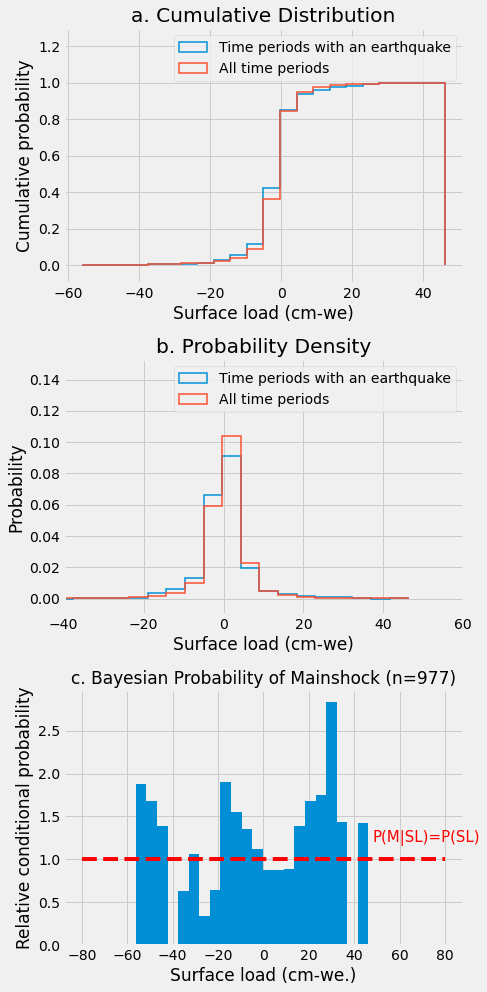

In [73]:
importlib.reload(loadquakes)
def set_of_figures_load(all_time, earthquake_only):

    fig,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(7,14))

    plt.style.use('fivethirtyeight')
    loadquakes.plot_hist(all_time, earthquake_only, ax1, ax2, 
              'a. Cumulative Distribution', 'b. Probability Density')

    loadquakes.plot_bayes(all_time, earthquake_only, ax3, 
                  'c. Bayesian Probability of Mainshock (n=977)')

    fig.tight_layout()
set_of_figures_load(ds['lwe_thickness'].data.flatten(), mainshock.dmass)

## Mapping earthquakes with high conditional probability

### First, calculate the conditional probability of each mainshock

<ipython-input-84-dd635c4c8f2e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainshock['cp'] = conditional_probability


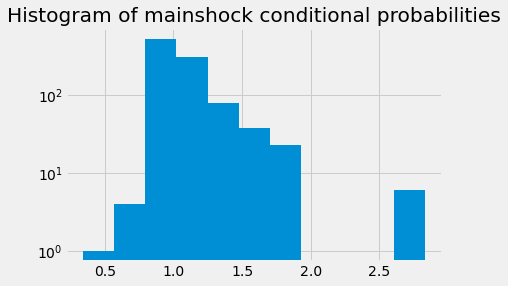

In [84]:
conditional_probability = loadquakes.get_cond_probability(
                            np.array(ds['lwe_thickness'].data.flatten()),
                            np.array(mainshock.dmass), np.array(mainshock.dmass))
mainshock['cp'] = conditional_probability
fig,ax=plt.subplots()
plt.hist(np.array(mainshock['cp']),11)
plt.title('Histogram of mainshock conditional probabilities')
plt.yscale('log')
# mainshock[mainshock.cp > 1.5].sort_values('cp')

### Next, map the events that have a conditional probability > 1.5                                       

In [105]:
mainshock[mainshock["cp"]>1.5].sort_values("magnitude")

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,dmass,cp
826,828,39.9847,24.3349,2020-09-26 22:50:25.082,5.4,POINT (39.9847 24.3349),5.4,0.0,5.736547e-11,0.882331,0.043585,1.0,-9.674045470605256,1.547613
4524,4526,4.1909,86.7252,2014-03-27 04:00:15.540,5.4,POINT (4.1909 86.7252),5.4,0.0,5.736547e-11,0.749881,0.187156,1.0,-11.677844038970811,1.547613
4728,4730,26.4118,93.6451,2013-11-06 04:16:16.060,5.4,POINT (26.4118 93.6451),5.4,0.0,5.736547e-11,0.891949,0.033159,1.0,-10.672265382677704,1.547613
5360,5362,40.7470,48.4370,2012-10-07 11:42:47.160,5.4,POINT (40.747 48.437),5.4,0.0,5.736547e-11,0.877871,0.048419,1.0,-11.138463404247345,1.547613
7456,7458,10.4340,-69.7150,2009-11-27 08:15:53.360,5.4,POINT (10.434 -69.715),5.4,0.0,5.736547e-11,0.876155,0.050279,1.0,27.24831784365442,1.744990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10109,10111,-6.2240,29.8300,2005-12-05 12:19:56.620,6.8,POINT (-6.224 29.83),5.4,0.0,5.736547e-11,0.606419,0.342664,1.0,-18.342497270476542,1.906710
3103,3105,20.9228,94.5690,2016-08-24 10:34:54.580,6.8,POINT (20.9228 94.569),5.4,0.0,5.736547e-11,0.886643,0.038911,1.0,27.319343214302634,1.744990
11190,11192,55.0721,-134.5324,2004-06-28 09:49:51.366,6.8,POINT (55.0721 -134.5324),5.4,0.0,5.736547e-11,0.893879,0.031067,1.0,-9.780644302562038,1.547613
6316,6318,20.6870,99.8220,2011-03-24 13:55:12.010,6.9,POINT (20.687 99.822),5.4,0.0,5.736547e-11,0.881793,0.044168,1.0,-10.507856801156215,1.547613


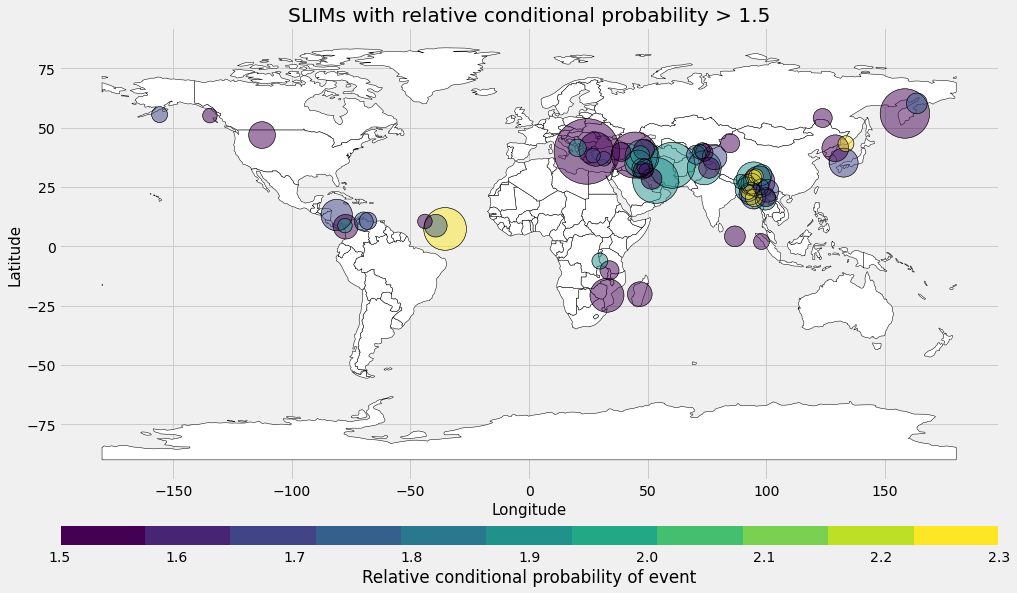

In [104]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

events_highcp = mainshock[mainshock['cp']>1.5]

def probability_map_cb(events,color,label):

    gdf = gpd.GeoDataFrame(events,
                           geometry=gpd.points_from_xy(events.longitude, 
                                                       events.latitude))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    cmap = cm.get_cmap('viridis', 11)    # 11 discrete colors
    gdf.plot(ax=ax,cax=cax,alpha=0.5,column=color,cmap=cmap,legend=True,
             edgecolor='k',
             markersize = 1e-5*np.sort(events.magnitude)[::-1]**10,
             legend_kwds={'label': "Relative conditional probability of event",
                            'orientation': "horizontal"},
            vmax=2.3,
            vmin=1.5)
    gdf.plot(ax=ax,facecolor="None",
         edgecolor='k',
         markersize = 1e-5*np.sort(events.magnitude)[::-1]**10)
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    ax.set_title(label)
    plt.show()

probability_map_cb(events_highcp,events_highcp.cp,
                'SLIMs with relative conditional probability > 1.5')

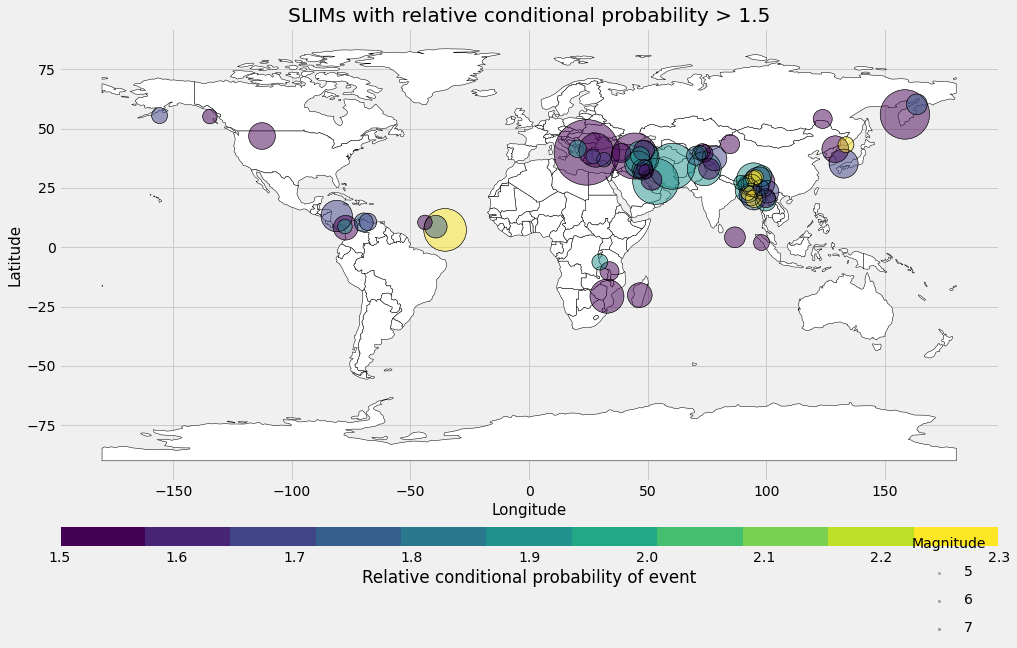

In [115]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

events_highcp = mainshock[mainshock['cp']>1.5]

def probability_map_cb(events,color,label):

    gdf = gpd.GeoDataFrame(events,
                           geometry=gpd.points_from_xy(events.longitude, 
                                                       events.latitude))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    cmap = cm.get_cmap('viridis', 11)    # 11 discrete colors
    gdf.plot(ax=ax,cax=cax,alpha=0.5,column=color,cmap=cmap,legend=True,
             edgecolor='k',
             markersize = 1e-5*np.sort(events.magnitude)[::-1]**10,
             legend_kwds={'label': "Relative conditional probability of event",
                            'orientation': "horizontal"},
            vmax=2.3,
            vmin=1.5)
    gdf.plot(ax=ax,facecolor="None",
         edgecolor='k',
         markersize = 1e-5*np.sort(events.magnitude)[::-1]**10)
    
    mag = events['magnitude']
    for mag in [5, 6, 7]:
        plt.scatter([], [], c='k', alpha=0.3, s=mag,
                    label=str(mag))
        plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Magnitude')
    
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    ax.set_title(label)
    plt.show()

probability_map_cb(events_highcp,events_highcp.cp,
                'SLIMs with relative conditional probability > 1.5')

In [116]:
events_highcp['magnitude']

826      5.4
842      6.4
997      5.5
1120     5.8
1201     5.5
        ... 
11970    5.8
11996    5.5
12285    5.6
12321    5.5
12445    5.6
Name: magnitude, Length: 66, dtype: float64

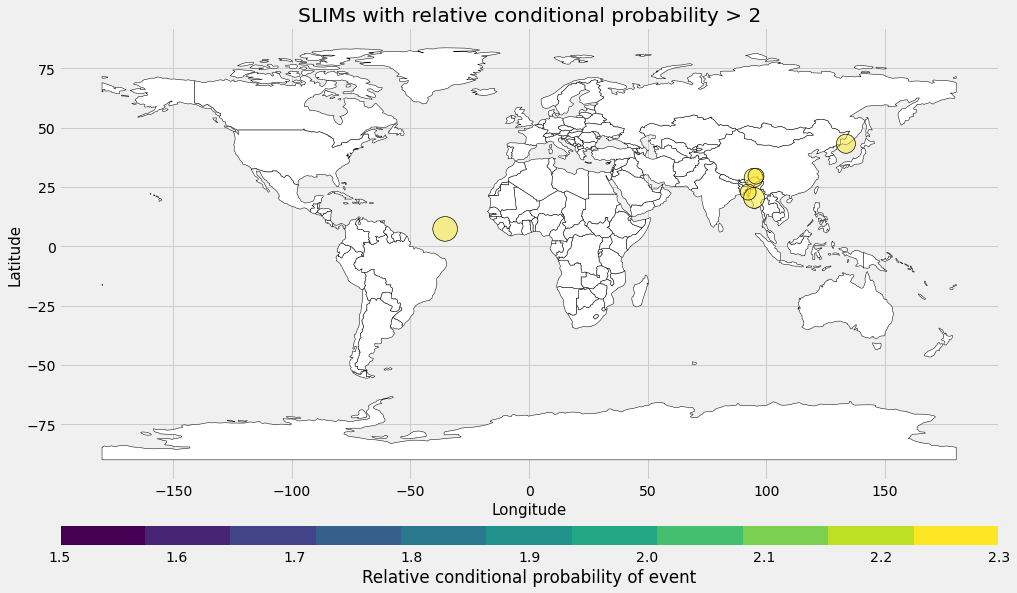

In [96]:
events_2 = mainshock[mainshock['cp']>2]

probability_map_cb(events_2,events_2.cp,
                'SLIMs with relative conditional probability > 2')

In [63]:
high_p = mainshock[mainshock["cp"]>1.5]
high_p[high_p["longitude"]<-100]

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,dmass,cp
2625,2627,46.8811,-112.5753,2017-07-06 06:30:17.000,5.8,POINT (46.8811 -112.5753),5.4,0.0,5.736547e-11,0.216708,0.765096,1.0,-10.294337778718495,1.547613
9460,9462,55.4948,-155.7421,2007-01-05 16:52:19.932,5.8,POINT (55.4948 -155.7421),5.4,0.0,5.736547e-11,0.872818,0.053897,1.0,21.576949719668733,1.680710
11190,11192,55.0721,-134.5324,2004-06-28 09:49:51.366,6.8,POINT (55.0721 -134.5324),5.4,0.0,5.736547e-11,0.893879,0.031067,1.0,-9.780644302562038,1.547613


## Correlation between mainshocks and rates of surface loading

### Calculate rates of loading

In [64]:
rates = ds['lwe_thickness'].diff('time')
rates.name = 'loading_rate'
ds['loading_rate'] = rates

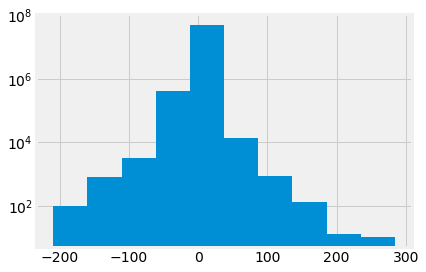

In [65]:
fig,ax=plt.subplots()
fig.patch.set_facecolor('w')
plt.hist(ds['loading_rate'].data.flatten())
plt.yscale('log')

In [66]:
def get_mass_rate(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["loading_rate"]
    return mass_change.data

mainshock['loading_rate'] = mainshock.apply(lambda row: get_mass_rate(row), axis=1)

<ipython-input-66-49c1da1e3fa6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainshock['loading_rate'] = mainshock.apply(lambda row: get_mass_rate(row), axis=1)


In [28]:
loadquakes.calc_stats(np.array(mainshock.loading_rate),np.array(ds['loading_rate'].data.flatten()))

{'cvm': CramerVonMisesResult(statistic=25093717328.75074, pvalue=0.0025406388631654675),
 'ks': KstestResult(statistic=0.04258563340857535, pvalue=0.3046628046046259),
 'median_all': nan,
 'median_eq': -0.1252215765497109,
 'mean_all': nan,
 'mean_eq': 0.0894192610713478,
 'mean_all_minus_mean_eq': nan,
 'median_all_minus_median_eq': nan}

In [ ]:
# np.nanmean(np.array(ds['loading_rate'].data.flatten()))

In [ ]:
# np.nanmedian(np.array(ds['loading_rate'].data.flatten()))

In [68]:
def set_of_figures_rate(all_time, earthquake_only):

    fig,(ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(6.5,12))

    plt.style.use('fivethirtyeight')
    loadquakes.plot_hist_rate(all_time, earthquake_only, ax1, ax2, 
              'A. Cumulative Distribution', 'B. Probability Density')

    loadquakes.plot_rel_hist_rate(all_time, earthquake_only, ax3, 
                  'C. Bayesian Probability of Earthquake (n=510)')

    fig.tight_layout()

In [69]:
set_of_figures_rate(ds['loading_rate'].data.flatten(), mainshock.loading_rate)

<ipython-input-68-dd41e40ce14d>:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


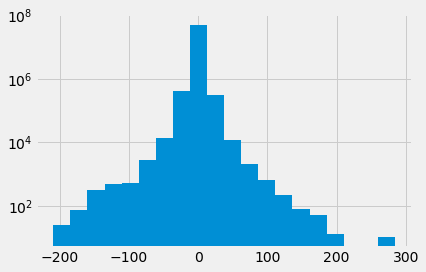

In [25]:
fig,ax=plt.subplots()
plt.hist(ds['loading_rate'].data.flatten(),20 )
plt.yscale('log')

In [71]:
conditional_probability_rate = loadquakes.get_cond_probability(
                                    np.array(ds['loading_rate'].data.flatten()),
                                    np.array(mainshock.loading_rate),
                                    np.array(mainshock.loading_rate))

mainshock['cp_rate'] = conditional_probability_rate

<ipython-input-71-09664389c60d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainshock['cp_rate'] = conditional_probability_rate


/home/amand4/.local/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


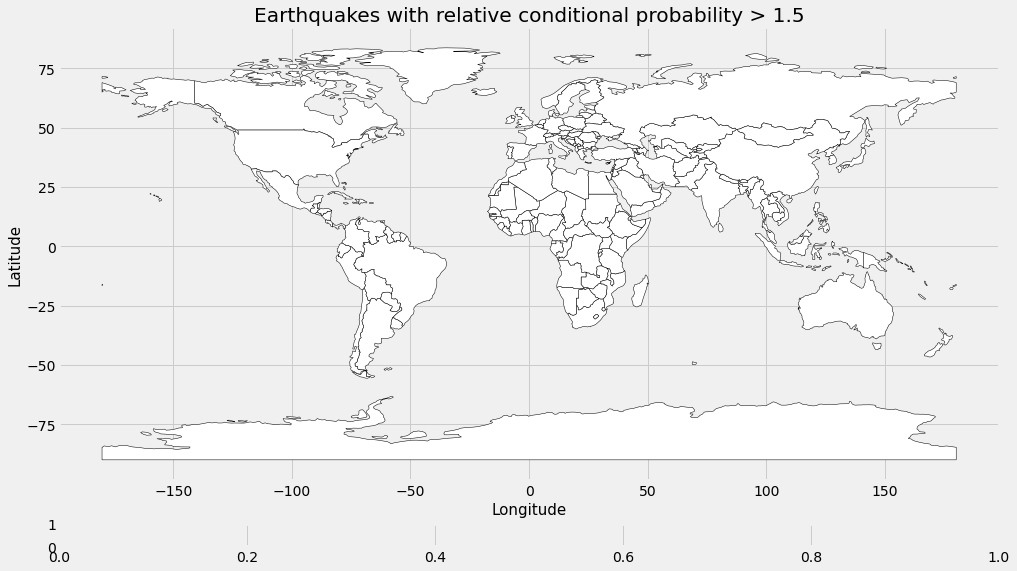

In [72]:
load_bounds = mainshock[mainshock['cp_rate']>1.5]

probability_map_cb(load_bounds,load_bounds.cp_rate,
                'Earthquakes with relative conditional probability > 1.5')

# Correlation between earthquakes and random data
##### *mean and std deviation of random array same as GRACE data 

In [197]:
random_load1 = np.random.normal(loc=-0.5782975724802435, scale=23.4860875337342, size=(194, 360, 720))

In [198]:
ds_random = ds

In [199]:
ds_random = ds_random.assign(load=ds_random['lwe_thickness'] - ds_random['lwe_thickness'] + random_load1)

In [200]:
ds_random['load']

<xarray.DataArray 'load' (time: 194, lat: 360, lon: 720)>
array([[[  2.42639426,  -4.46665108, -10.47158286, ..., -13.06400174,
          15.2509683 , -10.93409647],
        [-16.67475989,   3.07992435,  20.66447077, ..., -67.52700987,
          21.24322523,   5.06438688],
        [ 13.69974525,  11.41601577,  41.58511969, ...,  19.60714762,
          -6.95323236,   6.70671619],
        ...,
        [-18.03253154, -24.54620422, -11.64741678, ..., -37.93838914,
          -2.77697459,   7.12486321],
        [ 17.31327453,   0.23317593,   8.35072   , ...,  15.50322088,
           8.67510956,   5.8313534 ],
        [ -9.55597257,  15.86896248,  -0.29325392, ...,  28.30454204,
          24.89121376,  -4.62079017]],

       [[-35.43764388,  -0.44821768,  -4.8972808 , ..., -31.61831049,
           4.32266675,  -7.82323862],
        [  7.6661944 ,   9.06449415,  34.21572564, ..., -31.11485427,
          -6.80660744,  10.8287599 ],
        [-27.39398542,   9.23162278,  -7.28448338, ...,   3.58398731,
          19.18943402,  18.11722834],
...
        [ 16.13011439,  53.65602568, -27.24501548, ...,  -6.08457213,
          40.27414374,  16.77093372],
        [-30.41043568,   9.05559641,  -3.58562692, ..., -12.44141166,
         -38.51255376,  -9.66771349],
        [ 35.05677223,  10.4368678 ,   4.12491085, ...,  28.83568152,
          -6.44601523,  14.05503399]],

       [[  8.52229533,  30.51149074, -14.10173878, ..., -13.47408157,
           5.48473378,  12.18505342],
        [ 12.45872396,  12.85082076,   5.92513153, ...,  20.631442  ,
          29.97384174,  -6.32258246],
        [ 29.41291541,  17.75337987, -27.83053093, ...,   3.18190084,
         -16.64039799,  -4.0253663 ],
        ...,
        [ 30.1913433 ,  -9.69754367, -14.61325919, ...,   5.09469714,
         -36.95501973,  -1.36449938],
        [-21.11982072,  23.40203699,  21.46002826, ...,   5.6607712 ,
          36.93130793,  32.65376378],
        [-23.04892863, -43.05693666,  43.61687326, ..., -29.45686392,
           1.06410215, -20.95350202]]])
Coordinates:
  * time     (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-02-15
  * lon      (lon) float64 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75

In [ ]:
# earthquake catalog

mainshock_random = catalog[catalog['P_triggered']<.9]

In [202]:
def get_mass_random(eq):
    mass_change = ds_random.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["load"]
    return mass_change.data
  
mainshock_random['dmass'] = mainshock_random.apply(lambda row: get_mass_random(row), axis=1)

<ipython-input-202-1efc1d20fd8f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainshock_random['dmass'] = mainshock_random.apply(lambda row: get_mass_random(row), axis=1)


In [205]:
np.mean(mainshock_random['dmass'])

0.7010100884118273

In [206]:
np.std(mainshock_random['dmass'])

24.183244484132587

21
20


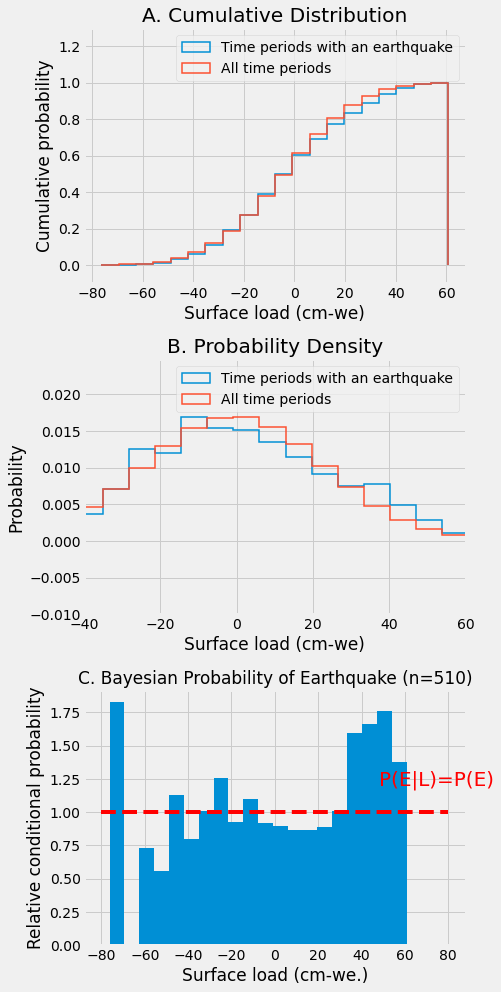

In [207]:
set_of_figures_load(ds_random['load'].data.flatten(), mainshock_random.dmass)

In [208]:
stats.ks_2samp(mainshock_random.dmass,ds_random['load'].data.flatten())

KstestResult(statistic=0.048805414944710246, pvalue=0.17035802763834784)